# Step 1 | Platform Setup

## Step 1.1 | Check Environment

In [1]:
!where python

C:\Anaconda\envs\tf-gpu\python.exe


In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3050 4GB Laptop GPU


## Step 1.2 | Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings

In [4]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [5]:
pd.set_option('display.max_columns', None)

# Step 2 | Load Data

In [6]:
long_df = pd.read_parquet("C:\\Users\\FaithanTo\\Desktop\\MSBA 6421 (001) Predictive Analytics\\m5-forecasting-accuracy\\LongDF_LSTM.parquet")

In [7]:
long_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,sales,date,weekday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,d_num
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,2011-01-29,Saturday,1,2011,NaN,NaN,0,0,0,2.0,1
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-30,Sunday,1,2011,NaN,NaN,0,0,0,2.0,2
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-31,Monday,1,2011,NaN,NaN,0,0,0,2.0,3
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,2011-02-01,Tuesday,2,2011,NaN,NaN,1,1,0,2.0,4
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,2011-02-02,Wednesday,2,2011,NaN,NaN,1,0,1,2.0,5


# Step 3 | Feature Importance Analysis

## Step 3.1 | Identify High Variance Hierarchical Levels

In [8]:
group_levels = ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id']

for level in group_levels:
    group_means = long_df.groupby(level, observed=True)['sales'].mean()
    group_variance = group_means.var()

    print(f"{level:<10} | Variance of group means: {group_variance:.2f}")

state_id   | Variance of group means: 0.01
store_id   | Variance of group means: 0.11
cat_id     | Variance of group means: 0.34
dept_id    | Variance of group means: 0.40
item_id    | Variance of group means: 5.35


**Analysis**

- Variance at higher levels (state, store) is very low.
- Aggregated Modeling would add major complexity while offering little in value.

We will proceed with a single LSTM model instead.

## Step 3.2 | Correlation Analysis

### Step 3.2.1 | Identify Numeric Columns

In [9]:
numeric_cols = long_df.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float32', 'float64']).columns

### Step 3.2.2 | Compute Correlation Matrix

In [10]:
corr_matrix = long_df[numeric_cols].corr()

### Step 3.2.3 | Plot Heatmap

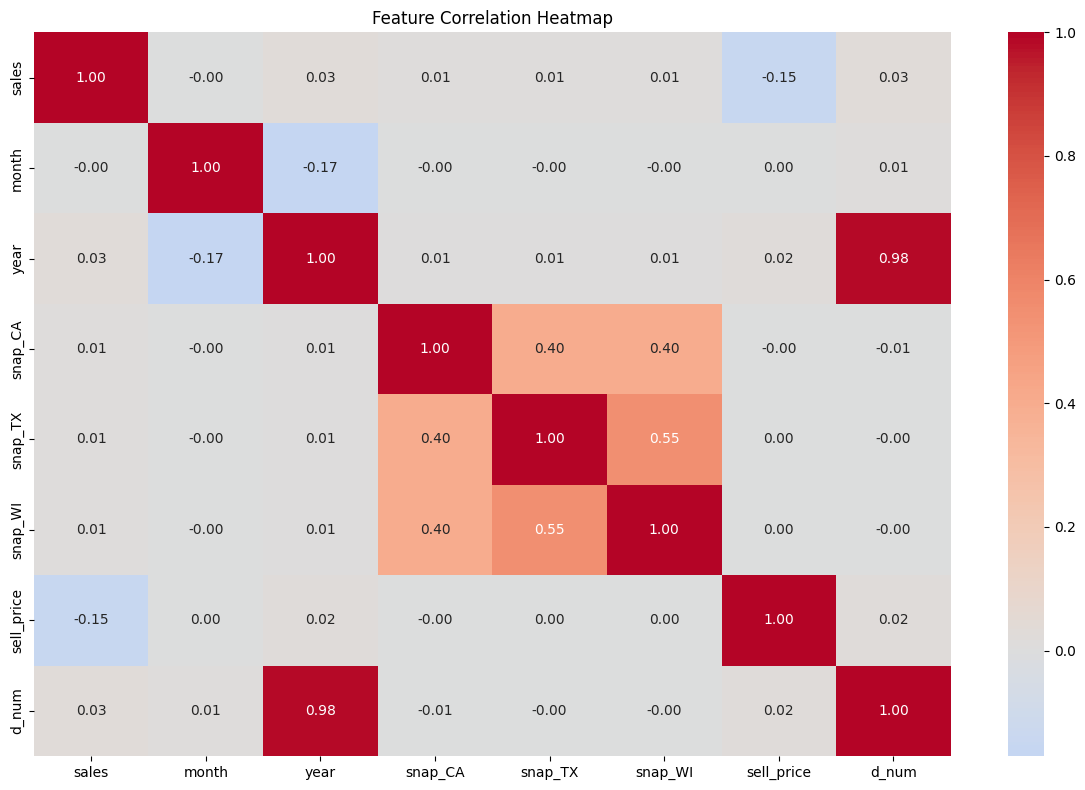

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# Step 4 | Feature Engineering

In [12]:
df_features = long_df

## Step 4.1 | 📦 Item-Store-Level Features

In [13]:
# 7-day rolling mean
df_features['store_item_rolling_mean_7d'] = df_features.groupby('id')['sales'].transform(lambda x: x.rolling(7, min_periods=1).mean())

# 30-day rolling std
df_features['store_item_rolling_std_30d'] = df_features.groupby('id')['sales'].transform(lambda x: x.rolling(30, min_periods=1).std())

## Step 4.2 | 🏬 Store-Level Features

### Step 4.2.1 | store_total_sales_7d

In [14]:
# Step 1: Aggregate sales per store per day (sum over all products for the same store and day)
df_store_sales = df_features.groupby(['store_id', 'd_num'], as_index=False)['sales'].sum()

# Step 2: Apply rolling sum on the aggregated sales (7-day rolling sum)
df_store_sales['store_total_sales_7d'] = df_store_sales.groupby('store_id')['sales']\
    .transform(lambda x: x.rolling(7, min_periods=1).sum())

# Step 3: Merge the aggregated store sales back into the original df_features
df_features = df_features.merge(
    df_store_sales[['store_id', 'd_num', 'store_total_sales_7d']],
    on=['store_id', 'd_num'],
    how='left'
)

### Step 4.2.2 | store_avg_item_sales_ratio

In [15]:
# Step 1: Aggregate sales per store per day (sum over all products for the same store and day)
df_store_sales = df_features.groupby(['store_id', 'd_num'], as_index=False)['sales'].sum()
df_store_sales.rename(columns={'sales': 'store_total_sales'}, inplace=True)

# Step 2: Calculate the store-item sales ratio for each product
store_item_sales = df_features.groupby(['store_id', 'd_num'])['sales'].transform('sum')
df_features['store_avg_item_sales_ratio'] = df_features['sales'] / (store_item_sales + 1e-6)  # avoid divide-by-zero

# Step 3: Merge the aggregated store sales back into the original df_features
df_features = df_features.merge(
    df_store_sales[['store_id', 'd_num', 'store_total_sales']], 
    on=['store_id', 'd_num'], 
    how='left'
)

# Step 4: Compute the store-item sales ratio using the store-level total sales
df_features['store_avg_item_sales_ratio'] = df_features['sales'] / (df_features['store_total_sales'] + 1e-6)

## Step 4.3 |  🗃️ Category / Department + Location Features

### Step 4.3.1 | Store × Category Rolling Mean (14 days)

In [16]:
# Step 1: Aggregate sales per category-store combination
cat_store_sales = df_features.groupby(['cat_id', 'store_id', 'd_num'], as_index=False)['sales'].sum()

# Step 2: Compute the rolling mean over 14 days for each category-store combination
cat_store_sales['store_cat_rolling_mean_14d'] = cat_store_sales.groupby(['cat_id', 'store_id'])['sales']\
    .transform(lambda x: x.rolling(14, min_periods=1).mean())

# Step 3: Merge the rolling mean back into the original df_features dataframe
df_features = df_features.merge(
    cat_store_sales[['cat_id', 'store_id', 'd_num', 'store_cat_rolling_mean_14d']],
    on=['cat_id', 'store_id', 'd_num'], 
    how='left'
)

### Step 4.3.2 | State × Dept Rolling Mean (30 days)

In [17]:
# Step 1: Aggregate sales per department-state combination
dept_state_sales = df_features.groupby(['dept_id', 'state_id', 'd_num'], as_index=False)['sales'].sum()

# Step 2: Compute the rolling mean over 30 days for each department-state combination
dept_state_sales['state_dept_rolling_mean_30d'] = dept_state_sales.groupby(['dept_id', 'state_id'])['sales']\
    .transform(lambda x: x.rolling(30, min_periods=1).mean())

# Step 3: Merge the rolling mean back into the original df_features dataframe
df_features = df_features.merge(
    dept_state_sales[['dept_id', 'state_id', 'd_num', 'state_dept_rolling_mean_30d']],
    on=['dept_id', 'state_id', 'd_num'],
    how='left'
)

## Step 4.4 | 🌎 State / Country-Level Features

### Step 4.4.1 | state_cat_prev_week_sales

In [18]:
# state_cat_prev_week_sales (Aggregated at the state, category level)

# Step 1: Aggregate sales at the state-category level
state_cat_sales = df_features.groupby(['state_id', 'cat_id', 'd_num'], as_index=False)['sales'].sum()

# Step 2: Shift sales by 1 week to get the previous week's sales for each state-category combination
state_cat_sales['state_cat_prev_week_sales'] = state_cat_sales.groupby(['state_id', 'cat_id'])['sales'].shift(7)

# Step 3: Merge the previous week sales back into the original df_features dataframe
df_features = df_features.merge(
    state_cat_sales[['state_id', 'cat_id', 'd_num', 'state_cat_prev_week_sales']],
    on=['state_id', 'cat_id', 'd_num'],
    how='left'
)

### Step 4.4.2 | state_cat_weekly_growth

In [19]:
# state_cat_weekly_growth (Aggregated at the state, category level)

# Step 1: Calculate weekly sales growth at the state-category level
state_cat_sales['prev_week_sales'] = state_cat_sales.groupby(['state_id', 'cat_id'])['sales'].shift(7)

# Step 2: Compute weekly growth as the percentage change from the previous week
state_cat_sales['state_cat_weekly_growth'] = (state_cat_sales['sales'] - state_cat_sales['prev_week_sales']) / (state_cat_sales['prev_week_sales'] + 1e-6)

# Step 3: Merge the weekly growth back into the original df_features dataframe
df_features = df_features.merge(
    state_cat_sales[['state_id', 'cat_id', 'd_num', 'state_cat_weekly_growth']],
    on=['state_id', 'cat_id', 'd_num'],
    how='left'
)

### Step 4.4.3 | country_sales

In [20]:
# Country-Level Sales Aggregation (Aggregated at the country level)

# Step 1: Aggregate sales across all stores and items by day
country_sales = df_features.groupby(['d_num'], as_index=False)['sales'].sum()

# Step 2: Rename the sales column to 'country_sales' for clarity
country_sales.rename(columns={'sales': 'country_sales'}, inplace=True)

# Step 3: Merge the country-level sales back into the original dataframe
df_features = df_features.merge(
    country_sales[['d_num', 'country_sales']],  # Now using 'country_sales' for the aggregated column
    on='d_num',  # Merging based on the day number
    how='left'  # Left join to keep all rows in the original dataframe
)

## Step 4.5 | 🗓️ sales_LY Features

### Step 4.5.1 | Create date_LY

In [22]:
df_features['date'] = pd.to_datetime(df_features['date'])
df_features['date_LY'] = df_features['date'] - pd.DateOffset(years=1)

### Step 4.5.2 | Create date → d_num Lookup

In [23]:
date_to_dnum = df_features[['date', 'd_num']].drop_duplicates().set_index('date')['d_num'].to_dict()
df_features['d_num_LY'] = df_features['date_LY'].map(date_to_dnum)

In [29]:
# # Rename d_num_x back to d_num (if it exists)

# if 'd_num_x' in df_features.columns:
#     df_features.rename(columns={'d_num_x': 'd_num'}, inplace=True)

# # Drop all the clutter columns if they exist
# columns_to_drop = ['d_num_y', 'sales_LY_x', 'sales_LY_y']
# df_features.drop(columns=[col for col in columns_to_drop if col in df_features.columns], inplace=True)

In [30]:
df_features2 = df_features

In [31]:
df_features2.head()

,id,item_id,dept_id,cat_id,store_id,state_id,sales,date,weekday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,d_num,store_item_rolling_mean_7d,store_item_rolling_std_30d,store_total_sales_7d,store_avg_item_sales_ratio,store_total_sales,store_cat_rolling_mean_14d,state_dept_rolling_mean_30d,state_cat_prev_week_sales,state_cat_weekly_growth,country_sales,date_LY,d_num_LY
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,2011-01-29,Saturday,1,2011,NaN,NaN,0,0,0,2.0,1,3.0,NaN,4337.0,0.000692,4337,3239.000000,1157.000000,NaN,NaN,32631,2010-01-29,NaN
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-30,Sunday,1,2011,NaN,NaN,0,0,0,2.0,2,1.5,2.121320,8492.0,0.000000,4155,3188.000000,1149.500000,NaN,NaN,31749,2010-01-30,NaN
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-31,Monday,1,2011,NaN,NaN,0,0,0,2.0,3,1.0,1.732051,11308.0,0.000000,2816,2794.666667,1028.666667,NaN,NaN,23783,2010-01-31,NaN
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,2011-02-01,Tuesday,2,2011,NaN,NaN,1,1,0,2.0,4,1.0,1.414214,14359.0,0.000328,3051,2660.500000,957.250000,NaN,NaN,25412,2010-02-01,NaN
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,2011-02-02,Wednesday,2,2011,NaN,NaN,1,0,1,2.0,5,1.6,1.816590,16989.0,0.001521,2630,2534.800000,911.600000,NaN,NaN,19146,2010-02-02,NaN


### Step 4.5.3 | Merge sales_LY Features

In [32]:
# ID-level

id_sales = df_features2[['id', 'd_num', 'sales']].rename(
    columns={'d_num': 'd_num_lookup', 'sales': 'sales_LY'}
)

df_features2 = df_features2.merge(
    id_sales,
    left_on=['id', 'd_num_LY'],
    right_on=['id', 'd_num_lookup'],
    how='left'
)

In [41]:
df_features2.head()

,id,item_id,dept_id,cat_id,store_id,state_id,sales,date,weekday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,d_num,store_item_rolling_mean_7d,store_item_rolling_std_30d,store_total_sales_7d,store_avg_item_sales_ratio,store_total_sales,store_cat_rolling_mean_14d,state_dept_rolling_mean_30d,state_cat_prev_week_sales,state_cat_weekly_growth,country_sales,date_LY,d_num_LY,d_num_lookup,sales_LY
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,2011-01-29,Saturday,1,2011,NaN,NaN,0,0,0,2.0,1,3.0,NaN,4337.0,0.000692,4337,3239.000000,1157.000000,NaN,NaN,32631,2010-01-29,NaN,NaN,NaN
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-30,Sunday,1,2011,NaN,NaN,0,0,0,2.0,2,1.5,2.121320,8492.0,0.000000,4155,3188.000000,1149.500000,NaN,NaN,31749,2010-01-30,NaN,NaN,NaN
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-31,Monday,1,2011,NaN,NaN,0,0,0,2.0,3,1.0,1.732051,11308.0,0.000000,2816,2794.666667,1028.666667,NaN,NaN,23783,2010-01-31,NaN,NaN,NaN
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,2011-02-01,Tuesday,2,2011,NaN,NaN,1,1,0,2.0,4,1.0,1.414214,14359.0,0.000328,3051,2660.500000,957.250000,NaN,NaN,25412,2010-02-01,NaN,NaN,NaN
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,2011-02-02,Wednesday,2,2011,NaN,NaN,1,0,1,2.0,5,1.6,1.816590,16989.0,0.001521,2630,2534.800000,911.600000,NaN,NaN,19146,2010-02-02,NaN,NaN,NaN


### Step 4.5.4 | Flag Missing Values

In [43]:
df_features2['is_new_id'] = df_features2['sales_LY'].isna().astype(int)

In [47]:
df_features2.head(100)

,id,item_id,dept_id,cat_id,store_id,state_id,sales,date,weekday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,d_num,store_item_rolling_mean_7d,store_item_rolling_std_30d,store_total_sales_7d,store_avg_item_sales_ratio,store_total_sales,store_cat_rolling_mean_14d,state_dept_rolling_mean_30d,state_cat_prev_week_sales,state_cat_weekly_growth,country_sales,date_LY,d_num_LY,d_num_lookup,sales_LY,is_new_id
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,2011-01-29,Saturday,1,2011,NaN,NaN,0,0,0,2.0,1,3.000000,NaN,4337.0,0.000692,4337,3239.000000,1157.000000,NaN,NaN,32631,2010-01-29,NaN,NaN,NaN,1
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-30,Sunday,1,2011,NaN,NaN,0,0,0,2.0,2,1.500000,2.121320,8492.0,0.000000,4155,3188.000000,1149.500000,NaN,NaN,31749,2010-01-30,NaN,NaN,NaN,1
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-31,Monday,1,2011,NaN,NaN,0,0,0,2.0,3,1.000000,1.732051,11308.0,0.000000,2816,2794.666667,1028.666667,NaN,NaN,23783,2010-01-31,NaN,NaN,NaN,1
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,2011-02-01,Tuesday,2,2011,NaN,NaN,1,1,0,2.0,4,1.000000,1.414214,14359.0,0.000328,3051,2660.500000,957.250000,NaN,NaN,25412,2010-02-01,NaN,NaN,NaN,1
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,2011-02-02,Wednesday,2,2011,NaN,NaN,1,0,1,2.0,5,1.600000,1.816590,16989.0,0.001521,2630,2534.800000,911.600000,NaN,NaN,19146,2010-02-02,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-05-04,Wednesday,5,2011,NaN,NaN,1,0,0,2.0,96,1.857143,1.449931,20349.0,0.000000,2610,1939.714286,831.966667,5143.0,0.286798,20761,2010-05-04,NaN,NaN,NaN,1
96,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-05-05,Thursday,5,2011,Cinco De Mayo,Cultural,1,1,1,2.0,97,1.857143,1.449931,20647.0,0.000000,2384,1931.785714,833.433333,5080.0,0.258268,21184,2010-05-05,NaN,NaN,NaN,1
97,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,9,2011-05-06,Friday,5,2011,NaN,NaN,1,1,1,2.0,98,3.142857,2.062528,21097.0,0.002880,3125,1935.214286,834.700000,6215.0,0.167337,24486,2010-05-06,NaN,NaN,NaN,1
98,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-05-07,Saturday,5,2011,NaN,NaN,1,1,0,2.0,99,2.714286,2.062528,21353.0,0.000000,3816,1913.500000,842.566667,7761.0,0.068934,28412,2010-05-07,NaN,NaN,NaN,1


# Step 5 | Memory Optimization

## Step 5.1 | Review Current Memory Usage

In [45]:
gc.collect()

3681

In [54]:
print(df_features2.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 33 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   id                           category      
 1   item_id                      category      
 2   dept_id                      category      
 3   cat_id                       category      
 4   store_id                     category      
 5   state_id                     category      
 6   sales                        int16         
 7   date                         datetime64[ns]
 8   weekday                      category      
 9   month                        int8          
 10  year                         int16         
 11  event_name_1                 category      
 12  event_type_1                 category      
 13  snap_CA                      int8          
 14  snap_TX                      int8          
 15  snap_WI                      int8          
 16

## Step 5.2 | Drop Redundant Columns

In [55]:
columns_to_drop = ['d_num_LY', 'd_num_lookup', 'date_LY']

In [56]:
df_features2.drop(columns=columns_to_drop, inplace=True)

## Step 5.3 | Downcast Numeric Columns

In [57]:
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype

        if pd.api.types.is_float_dtype(col_type):
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif pd.api.types.is_integer_dtype(col_type):
            df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

df_features2 = reduce_mem_usage(df_features2)

In [58]:
df_features2['date'] = pd.to_datetime(df_features2['date']).dt.date

## Step 5.4 | Review New Memory Usage

In [59]:
print(df_features2.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59181090 entries, 0 to 59181089
Data columns (total 30 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   id                           category
 1   item_id                      category
 2   dept_id                      category
 3   cat_id                       category
 4   store_id                     category
 5   state_id                     category
 6   sales                        int16   
 7   date                         object  
 8   weekday                      category
 9   month                        int8    
 10  year                         int16   
 11  event_name_1                 category
 12  event_type_1                 category
 13  snap_CA                      int8    
 14  snap_TX                      int8    
 15  snap_WI                      int8    
 16  sell_price                   float32 
 17  d_num                        int16   
 18  store_item_rolling_m

In [60]:
df_features3 = df_features2

# Step 6 | Imputations for NA Values

## Step 6.1 | Count NA Values Per Column

In [61]:
# Count and display NA values per column
na_counts = df_features3.isna().sum().sort_values(ascending=False)

# Show only columns with at least 1 NA
na_counts = na_counts[na_counts > 0]

# Display the result
print(na_counts)

event_name_1                  54363670
event_type_1                  54363670
sell_price                    12299413
sales_LY                      11128850
state_cat_weekly_growth         213430
state_cat_prev_week_sales       213430
store_item_rolling_std_30d       30490
dtype: int64


## Step 6.2 | Backfill Historical Sales Metrics

In [62]:
backfill_cols = ['sales_LY', 'state_cat_prev_week_sales', 'state_cat_weekly_growth', 'store_item_rolling_std_30d']
df_features3[backfill_cols] = df_features3[backfill_cols].fillna(method='bfill')

## Step 6.3 | Forward Fill & Backfill sell_price

In [63]:
df_features3['sell_price'] = df_features3.groupby('id')['sell_price'].ffill()
df_features3['sell_price'] = df_features3.groupby('id')['sell_price'].bfill()

## Step 6.4 | Fill NAs for Events

In [70]:
# Update categories before filling NaNs for categorical columns
df_features3['event_name_1'] = df_features3['event_name_1'].cat.add_categories(['No Event'])

ValueError: new categories must not include old categories: {'No Event'}

In [72]:
df_features3['event_type_1'] = df_features3['event_type_1'].cat.add_categories(['No Event Type'])

In [73]:
df_features3['event_name_1'].fillna('No Event', inplace=True)
df_features3['event_type_1'].fillna('No Event Type', inplace=True)

## Step 6.5 | Count NA Values Per Column

In [74]:
# Count and display NA values per column
na_counts = df_features3.isna().sum().sort_values(ascending=False)

# Show only columns with at least 1 NA
na_counts = na_counts[na_counts > 0]

# Display the result
print(na_counts)

Series([], dtype: int64)


# Step 7 | Export to Parquet File

In [75]:
df_features3.head()

,id,item_id,dept_id,cat_id,store_id,state_id,sales,date,weekday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,d_num,store_item_rolling_mean_7d,store_item_rolling_std_30d,store_total_sales_7d,store_avg_item_sales_ratio,store_total_sales,store_cat_rolling_mean_14d,state_dept_rolling_mean_30d,state_cat_prev_week_sales,state_cat_weekly_growth,country_sales,sales_LY,is_new_id
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,3,2011-01-29,Saturday,1,2011,No Event,No Event Type,0,0,0,2.0,1,3.0,2.121320,4337.0,0.000692,4337,3239.000000,1157.000000,10101.0,0.175131,32631,3.0,1
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-30,Sunday,1,2011,No Event,No Event Type,0,0,0,2.0,2,1.5,2.121320,8492.0,0.000000,4155,3188.000000,1149.500000,10101.0,0.175131,31749,3.0,1
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0,2011-01-31,Monday,1,2011,No Event,No Event Type,0,0,0,2.0,3,1.0,1.732051,11308.0,0.000000,2816,2794.666748,1028.666626,10101.0,0.175131,23783,3.0,1
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,1,2011-02-01,Tuesday,2,2011,No Event,No Event Type,1,1,0,2.0,4,1.0,1.414214,14359.0,0.000328,3051,2660.500000,957.250000,10101.0,0.175131,25412,3.0,1
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,4,2011-02-02,Wednesday,2,2011,No Event,No Event Type,1,0,1,2.0,5,1.6,1.816590,16989.0,0.001521,2630,2534.800049,911.599976,10101.0,0.175131,19146,3.0,1


In [76]:
# Export to Parquet file

df_features3.to_parquet('Step2_FeatureEngineering_LSTM.parquet', index=False)